## One-time installs

In [0]:
!nvidia-smi

#### Download and install NVIDIA Apex

In [2]:
!git clone https://github.com/NVIDIA/apex
% cd apex
!pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" .
% cd /content

Cloning into 'apex'...
remote: Enumerating objects: 168, done.
remote: Counting objects: 100% (168/168), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 4804 (delta 88), reused 117 (delta 63), pack-reused 4636
Receiving objects: 100% (4804/4804), 8.79 MiB | 23.26 MiB/s, done.
Resolving deltas: 100% (3100/3100), done.
/content/apex
/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py:244: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
Created temporary directory: /tmp/pip-ephem-wheel-cache-b9p46jwv
Created temporary directory: /tmp/pip-req-tracker-olo7w0e7
Created requirements tracker '/tmp/pip-req-tracker-olo7w0e7'
Created temporary directory: /tmp/pip-install-m52pmah3
Processing /content/apex
  Created temporary directory: /tmp/pip-req-build-xo_e1ag9
  Added file:///content/apex to build tracker '/tmp/pip-req-tracker-olo7w0e7'


#### Clone & install pretrained BERT repo

In [3]:
! git clone https://github.com/epsdg/pytorch-pretrained-BERT

import sys
sys.path.insert(0, 'pytorch-pretrained-BERT')

! pip install regex

Cloning into 'pytorch-pretrained-BERT'...
remote: Enumerating objects: 3993, done.
remote: Total 3993 (delta 0), reused 0 (delta 0), pack-reused 3993
Receiving objects: 100% (3993/3993), 2.12 MiB | 19.56 MiB/s, done.
Resolving deltas: 100% (2774/2774), done.
     |████████████████████████████████| 655kB 2.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/35/e4/80/abf3b33ba89cf65cd262af8a22a5a999cc28fbfabea6b38473
Successfully built regex


## 2. Main routine

In [4]:
import os
import sys
import shutil
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import logging
from datetime import datetime
import multiprocessing
import requests
import zipfile
from sklearn import metrics

import torch
from torch.utils.data import TensorDataset, DataLoader

from apex import amp

sys.path.insert(0, 'pytorch-pretrained-BERT')
from pytorch_pretrained_bert import convert_tf_checkpoint_to_pytorch
from pytorch_pretrained_bert import BertTokenizer, BertForSequenceClassification, BertAdam
from pytorch_pretrained_bert import BertConfig

print(f'n_cpus={multiprocessing.cpu_count()}')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device={device}, '+
      f'type: {torch.cuda.get_device_name(device)}, ' +
      f'CUDA capability: {torch.cuda.get_device_capability(device)}')

log_date = datetime.now().strftime('%m%d-%H%M')
logging.basicConfig(level=logging.DEBUG,
                    format='%(asctime)s: %(message)s',
                    datefmt='%H:%M:%S',
                    filename='/content/BERT-' + log_date + '.txt',
                    filemode='w')

logger1 = logging.getLogger('')

n_cpus=2
device=cuda, type: Tesla T4, CUDA capability: (7, 5)


#### Retrieve and init model

In [5]:
MODELS_DIR = '/content/models/BERT/'
SOURCE_PATH = 'https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip'

  # BASE models: 12 layers, Hdim 768, 12 heads
  # 'https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip'
  # 'https://storage.googleapis.com/bert_models/2018_10_18/cased_L-12_H-768_A-12.zip'

  # LARGE models: 24 layers, Hdim 1024, 16 heads
  # 'https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-24_H-1024_A-16.zip'
  # 'https://storage.googleapis.com/bert_models/2018_10_18/cased_L-24_H-1024_A-16.zip'

  # large, whole word masking
  # https://storage.googleapis.com/bert_models/2019_05_30/wwm_uncased_L-24_H-1024_A-16.zip
  # https://storage.googleapis.com/bert_models/2019_05_30/wwm_cased_L-24_H-1024_A-16.zip

model_fname = SOURCE_PATH.split('/')[-1]
model_path = os.path.join(MODELS_DIR, model_fname.split('.')[0])

if not os.path.exists(MODELS_DIR):
    os.makedirs(MODELS_DIR)

    r = requests.get(SOURCE_PATH, stream=True)
    with open(os.path.join(MODELS_DIR, model_fname), 'wb') as f:
        file_size = int(r.headers["content-length"])
        chunk_size = 1000
        for chunk in r.iter_content(chunk_size=chunk_size):
            f.write(chunk)

    with zipfile.ZipFile(os.path.join(MODELS_DIR, model_fname), 'r') as f:
        f.extractall(os.path.join(MODELS_DIR))
    os.remove(os.path.join(MODELS_DIR, model_fname))
    shutil.move(model_path + '/bert_config.json', model_path + '/config.json')
    
convert_tf_checkpoint_to_pytorch.convert_tf_checkpoint_to_pytorch(
    model_path + '/bert_model.ckpt',
    model_path + '/config.json',
    model_path + '/pytorch_model.bin')

Building PyTorch model from configuration: {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

Converting TensorFlow checkpoint from /content/models/BERT/uncased_L-12_H-768_A-12/bert_model.ckpt
Loading TF weight bert/embeddings/LayerNorm/beta with shape [768]
Loading TF weight bert/embeddings/LayerNorm/gamma with shape [768]
Loading TF weight bert/embeddings/position_embeddings with shape [512, 768]
Loading TF weight bert/embeddings/token_type_embeddings with shape [2, 768]
Loading TF weight bert/embeddings/word_embeddings with shape [30522, 768]
Loading TF weight bert/encoder/layer_0/attention/output/LayerNorm/beta with shape [768]
Loading TF weight bert/encoder/layer_0/attention/output/LayerNorm/gamm

#### Load & process data

In [7]:
TRAIN_VAL_SPLIT = 0.8

def get_inputs(df_in, train_val_split):
    # Returns: train_texts, train_labels, val_texts, val_labels
    #    ( _texts: np.array of str )
    #    ( labels: np.array of np.int64 )
    train_df = train1[:int(train1.shape[0]*train_val_split)]
    val_df = train1[int(train1.shape[0]*train_val_split):]
    
    train_texts = train_df.comment_text.values
    train_labels = train_df.target_int.values.astype('int')
    val_texts = val_df.comment_text.values
    val_labels = val_df.target_int.values.astype('int')
    
    return train_texts, train_labels, val_texts, val_labels

train_texts, train_labels, val_texts, val_labels = get_inputs(train1, TRAIN_VAL_SPLIT)

print(f'train records: {len(train_texts)} val records: {len(val_texts)}')

non-tox id 103445 non-tox 300000 tox 144334
(547779, 47)
train records: 438223 val records: 109556


#### Hyperparameters

In [0]:
MAX_LEN = 256
BATCH_SIZE = 32
N_EPOCHS = 1
ETA = 3e-6
OPTIMIZER_WARMUP = 0.05
LOG_INTERVAL = 500
AMP_OPT_LEVEL = 'O1'
GRAD_ACCUM_STEPS = 2

#### Tokenize train text samples

In [9]:
tokenizer = BertTokenizer.from_pretrained(model_path, cache_dir=None, do_lower_case=True)

def tokenize(sentences, tokenizer, max_len):
    ret = np.zeros((len(sentences), max_len))
    for i, sentence in enumerate(tqdm(sentences, mininterval=10)):
        tokens = tokenizer.tokenize(sentence)[:max_len-2]
        indexed_tokens = tokenizer.convert_tokens_to_ids(['[CLS]'] + tokens + ['[SEP]'])
        lens.append(len(indexed_tokens))
        ret[i, :len(indexed_tokens)] = indexed_tokens
    return ret

Xt = tokenize(train_texts, tokenizer, MAX_LEN)
yt = train_labels
train_ds = TensorDataset(torch.tensor(Xt,dtype=torch.long), torch.tensor(yt,dtype=torch.float))

100%|██████████| 438223/438223 [07:54<00:00, 923.51it/s]


#### Init model

In [0]:
model = BertForSequenceClassification.from_pretrained(model_path, cache_dir=None, num_labels=1)
model = model.to(device)

model_params = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model_params if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model_params if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}]

#### Train

In [0]:
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=ETA,
                     warmup=WARMUP,
                     t_total=N_EPOCHS * np.ceil(len(train_texts) / BATCH_SIZE))

model, optimizer = amp.initialize(model, optimizer, opt_level=AMP_OPT_LEVEL, verbosity=1)

model = model.train()

xentropy = torch.nn.functional.binary_cross_entropy_with_logits

losses = []

model.zero_grad()

logger1.info(f'Using uncased_L-12_H-768_A-12')
logger1.info(f'train hparams:\n   train recs: {len(train_texts):,}\n'
             + f'   max_len: {MAX_LEN}\n   n_epochs: {N_EPOCHS}\n'
             + f'   batch size: {BATCH_SIZE}\n   eta: {ETA}\n'
             + f'   warmup {OPTIMIZER_WARMUP}\n'
             + f'   accumulation steps: {GRAD_ACCUM_STEPS}\n'
             + f'   opt_level: {AMP_OPT_LEVEL}'
           )

for epoch in range(N_EPOCHS):
    logger1.info(f'epoch {epoch+1} of {N_EPOCHS} training:')

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    n_batches = len(train_loader)

    optimizer.zero_grad()
    tq = tqdm(enumerate(train_loader), total=n_batches, mininterval=30, maxinterval=60)
    loss_smoothed = None
    for step, batch in tq:
        X_batch = batch[0].to(device)
        y_batch = batch[1].view(-1,1).to(device)
        mask = (X_batch>0).to(device)
        y_pred = model(X_batch, attention_mask=mask, labels=None)        

        loss = xentropy(y_pred, y_batch).to(device)
        
        with amp.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward()

        if (step+1) % GRAD_ACCUM_STEPS == 0:
            optimizer.step()
            optimizer.zero_grad()

        batch_loss = loss.item()
        
        losses.append(batch_loss)

        if (step+1) % LOG_INTERVAL == 0:
            loss_mean  = sum(losses[(step+1-LOG_INTERVAL):]) / LOG_INTERVAL
            lr = optimizer.get_lr()[0]
            logstr = f'step {step+1} of {n_batches} loss {loss_mean:.4f} lr {lr:.4E}'
            logger1.info(logstr)
            tq.set_postfix(loss=loss_mean, lr=lr)

logger1.info('train complete.')

  0%|          | 0/13695 [00:00<?, ?it/s]

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


  1%|          | 143/13695 [01:31<2:23:26,  1.57it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


 12%|█▏        | 1616/13695 [17:35<2:11:51,  1.53it/s, loss=0.234, lr=2.99e-6]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


 42%|████▏     | 5802/13695 [1:03:13<1:26:00,  1.53it/s, loss=0.178, lr=2.52e-6]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


 51%|█████▏    | 7045/13695 [1:16:46<1:12:29,  1.53it/s, loss=0.17, lr=2.35e-6]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


 81%|████████  | 11047/13695 [2:00:22<28:49,  1.53it/s, loss=0.168, lr=1.89e-6]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


 96%|█████████▌| 13118/13695 [2:22:55<06:17,  1.53it/s, loss=0.166, lr=1.66e-6]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


100%|██████████| 13695/13695 [2:29:12<00:00,  1.53it/s, loss=0.164, lr=1.6e-6]


#### Save trained model
(optional)

In [0]:
SAVED_MODEL_FNAME = 'bert_pytorch.bin'
SAVED_MODEL_DIR = '/content/saved_models'
if not os.path.exists(SAVED_MODEL_DIR):
    os.makedirs(SAVED_MODEL_DIR)

torch.save(model.state_dict(), os.path.join(SAVED_MODEL_DIR, SAVED_MODEL_FNAME))
logger1.info(f'Model saved as {SAVED_MODEL_DIR + "/" + SAVED_MODEL_FNAME}')

#### Plot training loss

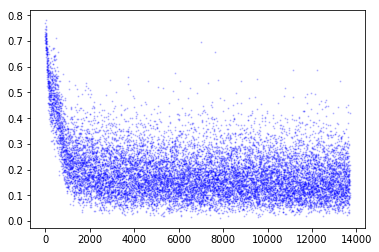

In [0]:
# train 438k eta 0.000003 batch 32 accum 2 loss 0.164 AUC 0.____
plt.plot(losses, 'o', color='b', ms=1, alpha=0.2);

#### Encode eval data

In [0]:
Xv = tokenize(val_texts, tokenizer, MAX_LEN)
yv = val_labels
val_ds = TensorDataset(torch.tensor(Xv,dtype=torch.long), torch.tensor(yv,dtype=torch.float))

100%|██████████| 109556/109556 [01:57<00:00, 933.06it/s]


#### Load trained model
Skip this step if training and evaluating in the same runtime.

In [0]:
SAVED_MODEL_FNAME = 'bert_pytorch.bin'
SAVED_MODEL_DIR = '/content/saved_models'
model.load_state_dict(torch.load(os.path.join(SAVED_MODEL_DIR, SAVED_MODEL_FNAME)))
logger1.info(f'Model loaded from {SAVED_MODEL_DIR + "/" + SAVED_MODEL_FNAME}')

#### Generate eval set predictions

In [0]:
model.to(device)
for param in model.parameters():
    param.requires_grad=False
model.eval()

val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

val_preds = []

tq = tqdm(enumerate(val_loader), total=len(val_loader), mininterval=10)
for i, batch in tq:
    X_batch = batch[0].to(device)
    logits_batch = model(X_batch,
                         attention_mask=(X_batch>0).to(device),
                         labels=None)
    preds_batch = torch.sigmoid(logits_batch[:, 0])
    preds_batch = preds_batch.detach().cpu().squeeze().tolist()
    val_preds.extend(preds_batch)

100%|██████████| 3424/3424 [13:42<00:00,  4.16it/s]


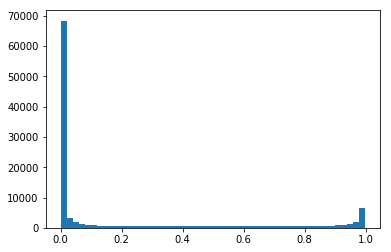

In [0]:
plt.hist(val_preds, bins=50);

#### Eval metrics

In [ ]:
from sklearn import metrics
val_preds = np.array(val_preds)
val_AUC = metrics.roc_auc_score(val_labels, val_preds)
val_acc = metrics.accuracy_score(val_labels.astype('int'), val_preds.astype('int'))
logger1.info(f'Eval set AUC = {val_AUC:.4f}')
logger1.info(f'Eval set accuracy = {val_acc:.4f}')
print(f'AUC {val_AUC:.4f}, acc {val_acc:.4f}')